In [2]:
%pip install torch
%pip install gym
%pip install matplotlib

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import gym

class DeepQNetwork(nn.Module):
    # 멤버 객체 설정 및 저장
    def __init__(self, lr, input_dims, fc1_dims, fc2_dims, n_actions):
        super(DeepQNetwork, self).__init__()
        self.input_dims = input_dims
        self.fc1_dims = fc1_dims
        self.fc2_dims = fc2_dims
        self.n_actions = n_actions
        self.fc1 = nn.Linear(self.input_dims, self.fc1_dims)
        self.fc2 = nn.Linear(self.fc1_dims, self.fc2_dims)
        self.fc3 = nn.Linear(self.fc2_dims, self.n_actions)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.loss = nn.MSELoss()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.to(self.device)
    # state를 받아서 각 action에 대한 예상 Q-value를 벡터로 반환 : Q(s)[a]
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        Q_vals_for_each_actions = self.fc3(x)
        return Q_vals_for_each_actions


class Agent():
    # 멤버 객체 설정 및 저장
    def __init__(self, gamma, epsilon, lr, input_dims, n_actions, batch_size, 
                 mem_size=100000, eps_min=0.01, eps_dec=2e-4):
        self.gamma = gamma
        self.epsilon = epsilon
        self.lr = lr
        self.input_dims = input_dims
        self.n_actions = n_actions
        self.batch_size = batch_size
        self.mem_size = mem_size
        self.eps_min = eps_min
        self.eps_dec = eps_dec

        self.action_space = [i for i in range(n_actions)]
        self.mem_cntr = 0

        self.Q_eval = DeepQNetwork(self.lr, n_actions=n_actions, 
                                   input_dims=input_dims, fc1_dims=16, fc2_dims=16)
        self.state_memory = torch.zeros((self.mem_size, input_dims), dtype=torch.float32)
        self.action_memory = torch.zeros(self.mem_size, dtype=torch.int32)
        self.reward_memory = torch.zeros(self.mem_size, dtype=torch.float32)
        self.next_state_memory = torch.zeros((self.mem_size, input_dims), dtype=torch.float32)
        self.terminal_memory = torch.zeros(self.mem_size, dtype=torch.bool)
    # s, a, r, s'을 history로 기록
    def store_transition(self, state, action, reward, next_state, done):
        index = self.mem_cntr % self.mem_size
        self.state_memory[index] = state
        self.action_memory[index] = action
        self.reward_memory[index] = reward
        self.next_state_memory[index] = next_state
        self.terminal_memory[index] = done
        self.mem_cntr += 1
    # s를 받아서 DeepQNetwork으로부터 얻은 Q(s)[a]에 따라 greedy action 선택
    def choose_action(self, state):
        if np.random.random() > self.epsilon:
            state = state.clone().detach().to(self.Q_eval.device)
            Q_vals_for_each_actions = self.Q_eval.forward(state)
            action = torch.argmax(Q_vals_for_each_actions).item()
        else:
            action = np.random.choice(self.action_space).item()
        return action
    # learn를 main에서 반복 호출하면 학습이 진행됨
    def learn(self):
        if self.mem_cntr < self.batch_size:
            return
        self.Q_eval.optimizer.zero_grad()
        max_mem = min(self.mem_cntr, self.mem_size)
        batch = np.random.choice(max_mem, size=self.batch_size, replace=False)
        batch_index = torch.arange(self.batch_size, dtype=torch.int32)

        state_batch = self.state_memory[batch].to(self.Q_eval.device)
        action_batch = self.action_memory[batch].to(self.Q_eval.device)
        reward_batch = self.reward_memory[batch].to(self.Q_eval.device)
        next_state_batch = self.next_state_memory[batch].to(self.Q_eval.device)
        terminal_batch = self.terminal_memory[batch].to(self.Q_eval.device)
        # print(*map(lambda x : x.size(), [state_batch, action_batch, reward_batch, next_state_batch, terminal_batch]))

        q = self.Q_eval.forward(state_batch)[batch_index, action_batch]
        q_next = self.Q_eval.forward(next_state_batch)
        q_next[terminal_batch] = 0.0
        q_target = reward_batch + self.gamma * torch.max(q_next, dim=1)[0]
        loss = self.Q_eval.loss(q_target, q).to(self.Q_eval.device)
        loss.backward()
        self.Q_eval.optimizer.step()

        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_min else self.eps_min

if __name__ == '__main__':
    # OpenAI gym 환경 생성
    env = gym.make('CartPole-v1')
    # 앞서 정의한 Agent 클래스의 객체 생성
    agent = Agent(gamma=0.99, epsilon=1.0, batch_size=64, n_actions=2,
                    eps_min=0.01, input_dims=4, lr=0.003)
    # 변수 선언
    score_history, eps_history = [], []
    n_games = 500

    # 게임을 여러 차례 돌린다
    for i in range(n_games):
        # 변수 선언
        score = 0
        done = False
        state, _ = env.reset()
        state = torch.Tensor(state)
        # 게임 종료 전까지 s, a, r, s' 생성, 학습 및 기록
        while not done:
            action = agent.choose_action(state)
            next_state, reward, done, _, info = env.step(action)
            score += reward
            state = torch.Tensor(state)
            next_state = torch.Tensor(next_state)
            agent.store_transition(state, action, reward, next_state, done)
            agent.learn()
            state = next_state
        # 최종 점수 및 epsilon 기록, 평균 점수 기록
        score_history.append(score)
        eps_history.append(agent.epsilon)
        avg_score = np.mean(score_history[-100:])
        # 중요 정보 출력
        print('episode ', i, 'score %.2f' % score,
            'average score %.2f' % avg_score,
            'epsilon %.2f' % agent.epsilon)
        # Plot learning curve
        x = [i+1 for i in range(n_games)]
        filename = 'CartPole.png'

/opt/homebrew/lib/python3.11/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


episode  0 score 15.00 average score 15.00 epsilon 1.00
episode  1 score 17.00 average score 16.00 epsilon 1.00
episode  2 score 11.00 average score 14.33 epsilon 1.00
episode  3 score 11.00 average score 13.50 epsilon 1.00
episode  4 score 16.00 average score 14.00 epsilon 1.00
episode  5 score 15.00 average score 14.17 epsilon 1.00
episode  6 score 27.00 average score 16.00 epsilon 0.99
episode  7 score 20.00 average score 16.50 epsilon 0.99
episode  8 score 9.00 average score 15.67 epsilon 0.98
episode  9 score 24.00 average score 16.50 epsilon 0.98
episode  10 score 19.00 average score 16.73 epsilon 0.98
episode  11 score 17.00 average score 16.75 epsilon 0.97
episode  12 score 11.00 average score 16.31 epsilon 0.97
episode  13 score 20.00 average score 16.57 epsilon 0.97
episode  14 score 13.00 average score 16.33 epsilon 0.96
episode  15 score 15.00 average score 16.25 epsilon 0.96
episode  16 score 18.00 average score 16.35 epsilon 0.96
episode  17 score 19.00 average score 16.5

In [5]:
import matplotlib.pyplot as plt

# Learning curve 그리기
def plot_learning_curve(x, score_history, eps_history, filename, lines=None):
    fig=plt.figure()
    ax1=fig.add_subplot(111, label="1")
    ax2=fig.add_subplot(111, label="2", frame_on=False)

    ax1.plot(x, eps_history, color="red")
    ax2.plot(x, score_history, color="black")
    ax1.set_xlabel("Training Steps", color="black")
    ax1.set_ylabel("Epsilons / rewards", color="red")
    ax1.tick_params(axis='x', colors="red")
    ax1.tick_params(axis='y', colors="red")

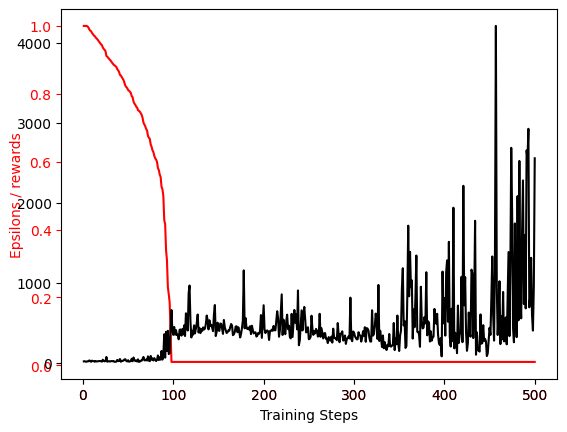

In [6]:
plot_learning_curve(x, score_history, eps_history, filename)